# 3er entrega - Sistemas de recomendación

En esta entrega vamos a trabajar con un sistema de recomendación.

Vamos a aprovechar la competencia de Telecom que vimos ya que los datos son reales y están buenos para practicar.

En el siguiente repositorio pueden encontrar el significado de cada columna de los datasets:
https://github.com/Datathon2021/Recomendador

Consigna:

- Dividir set en train y test. Tomar como train los datos hasta el 1 de marzo de 2021. Desde el 1ro de marzo en adelante, reservar para test.
- Desarrollar un recomendador. El recomendador debe ser capaz de generar recomendaciones para TODOS los usuarios (incluyendo los cold start que no tengan visualizaciones en el set de train). Generar 20 recomendaciones por usuario.
- Las recomendaciones tienen que ser para cada account_id y hay que recomendar content_id (NO asset_id). Pueden encontrar esto en el repositorio de la competencia.
- Los contenidos que recomienden, no tienen que haber sido vistos previamente por los usuarios (filtrar).
- Evaluarlo con MAP.

Recomendaciones:
- En este caso no tenemos ratings explícitos como los casos que vimos, deben generar ustedes estos ratings mediante algún criterio. Lo más simple podría ser utilizar ratings binarios (lo vió / no lo vió).
- Hay una columna que nos indica hasta cuando va a estar disponible el contenido
- La columna **end_vod_date**: "fecha de finalización de la disponibilidad del activo en la plataforma" puede llegar a serles muy útil. ¿Tiene sentido recomendar algo que no va a estar disponible en el set de test? (a partir del 1 de marzo de 2021).
- Comiencen con algo SIMPLE. No se compliquen con todas las columnas que tiene el dataset. No van a necesitar usar todas, muchas columnas podrán descartarlas dependiendo del enfoque que tomen.

Datos:
- https://drive.google.com/file/d/1QjbqJvU0PTClEhReOyzr96BS-HpyyUKT/view?usp=sharing
- https://drive.google.com/file/d/1ih6SZc44w8FXdFKQJ2l-aqEWFpfceGuN/view?usp=sharing

Fecha de entrega: **30 de Enero de 2023**.

Subir a un repositorio de github (público) y enviar el link a alexispacek@gmail.com. De paso les sirve para ir armando su perfil de github con algunos proyectos 😉.



In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from lightfm import LightFM

c:\Users\catah\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# Preparando dataset

## Inputs

In [2]:
df_train = pd.read_csv('train.csv')
metadata = pd.read_csv('metadata.csv', sep=';')

In [3]:
df_train.head(5)

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [4]:
metadata.head(5)

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26T11:58:44.0Z,2019-11-15T03:00:23.0Z,2018-05-27T00:00:00.0Z,2021-04-30T23:59:59.0Z
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03T20:07:24.0Z,2020-04-09T04:37:29.0Z,2019-05-02T00:00:00.0Z,2020-12-31T23:59:59.0Z


## Dataframe

### train

* customer_id: código de identificación de cada cliente de Flow (puede tener asociados uno o más account_id)

* account_id: código de identificación de cada perfil de Flow (se corresponde con un único customer_id)

* device_type: indica el tipo de dispositivo desde el que se efectuó la visualización. Las categorías posibles son:

    * CLOUD: cliente web

    * PHONE: teléfono celular

    * STATIONARY: smart TV

    * STB: set-top box, el decodificador Flow

    * TABLET

* asset_id: código de identificación de cada activo (video) disponible en la plataforma

* tunein: fecha y hora de inicio de cada visualización

* tuneout: fecha y hora de finalización de cada visualización

* resume: variable dummy que indica si se reanuda un consumo anterior del mismo asset_id

In [5]:
df_train_columns = ['customer_id', 'asset_id']
df_train_columns_view = ['tunein', 'tuneout']

df_train = pd.read_csv('train.csv')
df_train = df_train[df_train_columns + df_train_columns_view]

df_train

,customer_id,asset_id,tunein,tuneout
0,0,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0
1,0,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0
2,1,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0
3,1,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0
4,1,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0
...,...,...,...,...
3657796,112339,330.0,2021-03-31 22:10:00.0,2021-03-31 22:22:00.0
3657797,112339,9931.0,2021-03-31 22:22:00.0,2021-03-31 22:34:00.0
3657798,112339,29929.0,2021-03-31 22:34:00.0,2021-03-31 22:46:00.0
3657799,112339,29929.0,2021-03-31 23:09:00.0,2021-03-31 23:13:00.0


### metadata

* asset_id: código de identificación de cada activo (video) disponible en Flow

* content_id: código de identificación que agrupa los distintos asset_id asociados a un mismo contenido (por ejemplo, cada episodio de una misma serie tiene su propio asset_id, mientras que la serie se identifica con un content_id único)

* title: título

* reduced_title: título reducido

* episode_title: título del episodio (válido para contenidos episódicos, como las series)

* show_type: tipo de show - las categorías son autorreferenciales con excepción de “Rolling”, que indica que se trata de una serie incompleta, y “Web”, la cual remite a contenidos pensados íntegramente en formato digital (series web) -

* released_year: año de lanzamiento

* country_of_origin: país de origen – expresado con el código de dos letras propio del estándar internacional de normalización ISO 3166 -

* category: categoría o género al que pertenece el contenido - puede haber una o más -

* keywords: palabras clave o tags asociadas al contenido - puede haber una o más -

* description: descripción (sinopsis)

* reduced_desc: descripción (sinopsis) reducida

* cast_first_name: nombre y apellido de los actores y actrices principales

* credits_first_name: nombre y apellido del director o directora

* **run_time_min: duración total, expresada en minutos**

* audience: audiencia target

* made_for_tv: variable dummy que indica si el contenido fue hecho para TV

* close_caption: variable dummy que indica si el contenido posee subtítulos

* sex_rating: variable dummy que indica si el contenido tiene escenas de sexo explícitas

* violence_rating: variable dummy que indica si el contenido tiene escenas de violencia explícitas

* language_rating: variable dummy que indica si el contenido posee lenguaje que puede ser considerado ofensivo o inapropiado

* dialog_rating: variable dummy que indica si el contenido posee diálogos que pueden ser considerado ofensivos o inapropiados

* fv_rating: variable dummy que indica si el contenido tiene rating de FV, que corresponde a público infantil con violencia ficticia

* pay_per_view: variable dummy que indica si se trata de un alquiler

* pack_premium_1: variable dummy que indica si se trata de un contenido exclusivo del pack premium 1

* pack_premium_2: variable dummy que indica si se trata de un contenido exclusivo del pack premium 2

* create_date: fecha de creación del activo

* modify_date: fecha de modificación del activo

* start_vod_date: fecha desde la cual el activo se encuentra disponible en la plataforma

* end_vod_date: fecha de finalización de la disponibilidad del activo en la plataforma

Las columnas binarias son todas negativas, no agregan valor

In [8]:
metadata = pd.read_csv('metadata.csv', sep=';')

metadata_columns_BIN = ['sex_rating', 'violence_rating', 'language_rating', 'dialog_rating', 'fv_rating']
metadata[metadata_columns_BIN].value_counts()

sex_rating  violence_rating  language_rating  dialog_rating  fv_rating
N           N                N                N              N            33144
dtype: int64

La metadata posee la duración total de cada asset.

Esta info, combinado con el tiempo total que el usuario estuvo viendo el asset, puede darnos info de valor para desarrollar una **Matriz**

In [9]:
metadata_columns = ['asset_id', 'run_time_min', 'title']

metadata_columns_OHE = ['released_year', 'category', 'audience', 'country_of_origin', 'show_type']
metadata_columns_BIN = ['sex_rating', 'violence_rating', 'language_rating', 'dialog_rating', 'fv_rating']
metadata_columns_NLP = ['keywords', 'cast_first_name', 'credits_first_name']

metadata = pd.read_csv('metadata.csv', sep=';')
metadata = metadata[metadata_columns]

metadata

,asset_id,run_time_min,title
0,15188,48.0,Ep:17 Tiempos Compulsivos
1,24940,105.0,7 Cajas
2,21939,82.0,La Maldición de las Hormigas Gigantes
3,9005,99.0,Una Mujer Fantástica
4,7391,126.0,Star Trek
...,...,...,...
33139,3683,64.0,T:1 Ep:03 Allen V. Farrow
33140,16810,56.0,T:1 Ep:01 Allen V. Farrow
33141,20468,24.0,T:2 Ep:34 Programa De Talentos
33142,3779,42.0,T:2 Ep:05 Batwoman


### Dataframe

In [10]:
df = pd.merge(df_train, metadata, on="asset_id", how='left')
df.tunein = pd.to_datetime(df.tunein)
df.tuneout = pd.to_datetime(df.tuneout)


df

,customer_id,asset_id,tunein,tuneout,run_time_min,title
0,0,18332.0,2021-02-18 22:52:00,2021-02-18 23:35:00,43.0,T:5 Ep:08 This is Us
1,0,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,42.0,T:5 Ep:10 This is Us
2,1,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,54.0,T:1 Ep:02 Big Little Lies
3,1,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,54.0,T:1 Ep:02 Big Little Lies
4,1,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,49.0,T:1 Ep:02 Dime quién soy
...,...,...,...,...,...,...
3657796,112339,330.0,2021-03-31 22:10:00,2021-03-31 22:22:00,12.0,T:1 Ep:35 Mickey: Aventuras sobre ruedas
3657797,112339,9931.0,2021-03-31 22:22:00,2021-03-31 22:34:00,12.0,T:1 Ep:38 Mickey: Aventuras sobre ruedas
3657798,112339,29929.0,2021-03-31 22:34:00,2021-03-31 22:46:00,12.0,T:1 Ep:39 Mickey: Aventuras sobre ruedas
3657799,112339,29929.0,2021-03-31 23:09:00,2021-03-31 23:13:00,12.0,T:1 Ep:39 Mickey: Aventuras sobre ruedas


# ETL

Eliminamos nulos

In [11]:
print(df.isna().sum().sum())
df.dropna(inplace=True)
print(df.isna().sum().sum())

66
0


In [12]:
type(df['asset_id'])

pandas.core.series.Series

In [13]:
df['asset_id'] = df['asset_id'].astype(int)

Calculamos el tiempo visualizando el asset, y sacamos el porcentaje en base a la duración total

In [14]:
df['asset_id'] = df['asset_id'].astype('int')
df['total_time'] = ((df.tuneout-df.tunein).dt.total_seconds()/60).astype('int')
df['run_time_min'] = df['run_time_min'].astype('int')
df['view'] = round(
                (df.total_time/df.run_time_min) \
                .apply(lambda x : 1 if x>1 else x),
                2)

df

,customer_id,asset_id,tunein,tuneout,run_time_min,title,total_time,view
0,0,18332,2021-02-18 22:52:00,2021-02-18 23:35:00,43,T:5 Ep:08 This is Us,43,1.00
1,0,24727,2021-03-24 23:17:00,2021-03-25 00:01:00,42,T:5 Ep:10 This is Us,44,1.00
2,1,895,2021-03-15 10:05:00,2021-03-15 10:23:00,54,T:1 Ep:02 Big Little Lies,18,0.33
3,1,895,2021-03-15 10:23:00,2021-03-15 11:18:00,54,T:1 Ep:02 Big Little Lies,55,1.00
4,1,26062,2021-03-16 09:24:00,2021-03-16 09:44:00,49,T:1 Ep:02 Dime quién soy,20,0.41
...,...,...,...,...,...,...,...,...
3657796,112339,330,2021-03-31 22:10:00,2021-03-31 22:22:00,12,T:1 Ep:35 Mickey: Aventuras sobre ruedas,12,1.00
3657797,112339,9931,2021-03-31 22:22:00,2021-03-31 22:34:00,12,T:1 Ep:38 Mickey: Aventuras sobre ruedas,12,1.00
3657798,112339,29929,2021-03-31 22:34:00,2021-03-31 22:46:00,12,T:1 Ep:39 Mickey: Aventuras sobre ruedas,12,1.00
3657799,112339,29929,2021-03-31 23:09:00,2021-03-31 23:13:00,12,T:1 Ep:39 Mickey: Aventuras sobre ruedas,4,0.33


In [21]:
df['watched']= df['view'].apply(lambda x : True if x >0.4 else False)

Tiempos

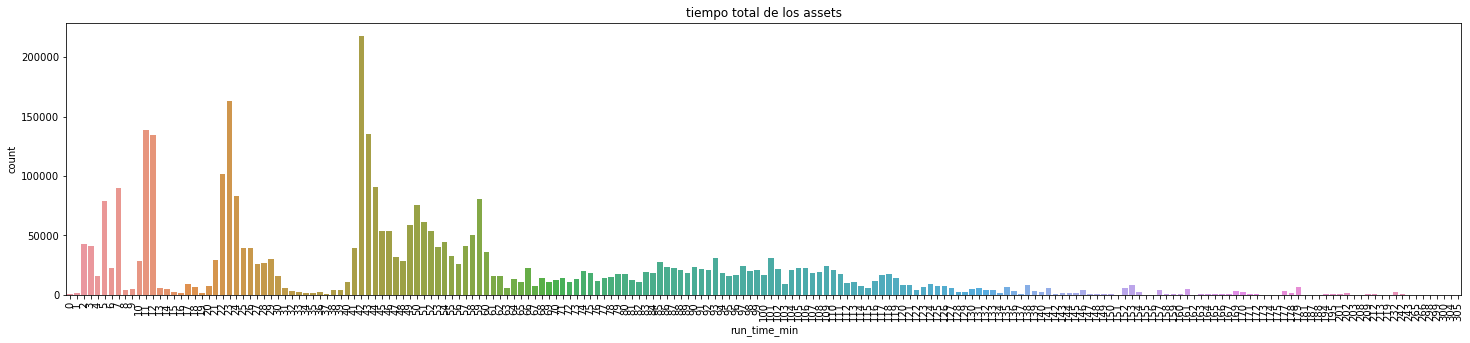

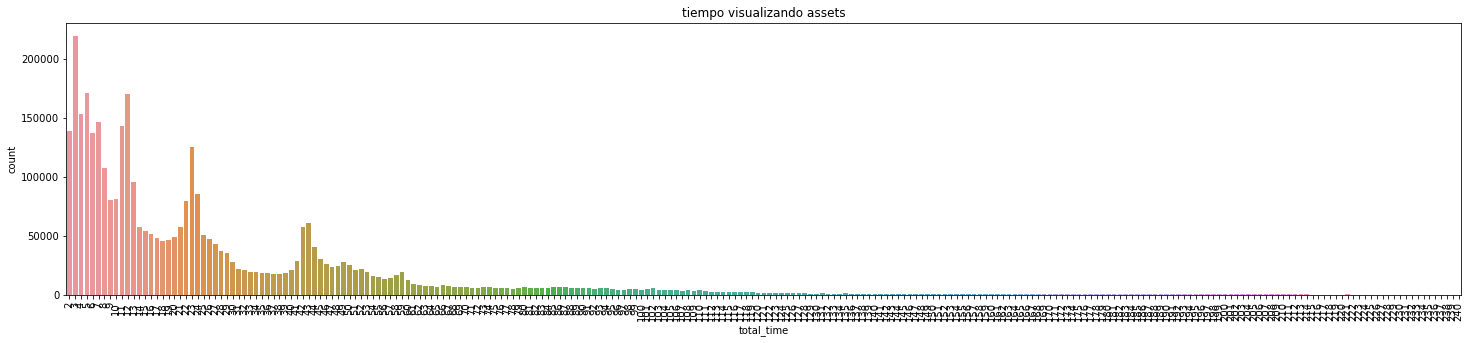

In [15]:
minimo = df['run_time_min'].min()
maximo = df['run_time_min'].max()

plt.figure(figsize=(25, 5))
plt.xticks(rotation = 90)
# plt.xlim(minimo,maximo)
plt.title('tiempo total de los assets')
sns.countplot(x=df['run_time_min'])
plt.show()

plt.figure(figsize=(25, 5))
plt.xticks(rotation = 90)
plt.title('tiempo visualizando assets')
# plt.xlim(minimo,maximo)
sns.countplot(x=df['total_time'])
plt.show()

In [31]:
plot_df = df.copy()
plot_df = plot_df.groupby("view", as_index=False).count()[["view", "customer_id"]]
plot_df.columns = ["view", "count_customer_id"]
plot_df.head(20)

,view,count_customer_id
0,0.01,4031
1,0.02,44727
2,0.03,68145
3,0.04,70516
4,0.05,73196
5,0.06,57173
6,0.07,72193
7,0.08,53483
8,0.09,53871
9,0.10,51372


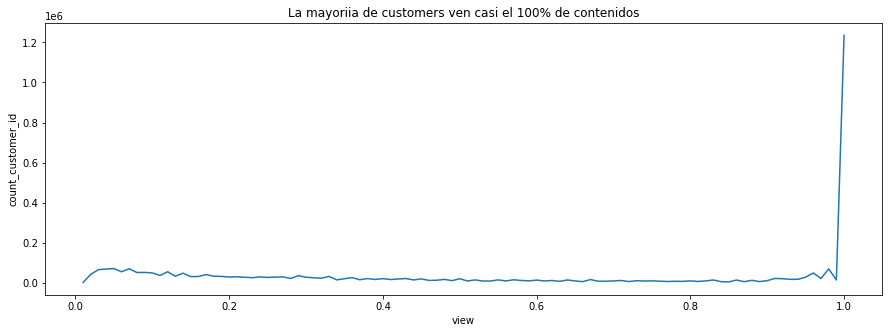

In [33]:

plt.figure(figsize=(15,5))
sns.lineplot(x=plot_df.view, y=plot_df.count_customer_id)
plt.title("La mayoriia de customers ven casi el 100% de contenidos")
plt.show()

In [37]:
plot_df = df.copy()
plot_df["month"] = df.tunein.dt.month
plot_df = plot_df.groupby("month", as_index=False).count()[["month", "customer_id"]]
plot_df.columns = ["month", "count_customer_id"]
plot_df.head()

,month,count_customer_id
0,1,1216469
1,2,1122595
2,3,1318715


## Split

Nos quedamos únicamente con la fecha de visualización, y realizamos el Split en base a la fecha planteada por el ejercicio

In [40]:
df.split_column = df.tunein.apply(lambda x: x.replace(tzinfo=None).date())


C:\Users\catah\AppData\Local\Temp\ipykernel_13552\1721157395.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.split_column = df.tunein.apply(lambda x: x.replace(tzinfo=None).date())


In [41]:
train = df[df.split_column < datetime(2021, 3, 1).date()]
test = df[df.split_column >= datetime(2021, 3, 1).date()]

In [42]:
train

,customer_id,asset_id,tunein,tuneout,run_time_min,title,total_time,view,watch,watched
0,0,18332,2021-02-18 22:52:00,2021-02-18 23:35:00,43,T:5 Ep:08 This is Us,43,1.00,True,True
6,2,30840,2021-01-01 02:22:00,2021-01-01 02:34:00,43,T:1 Ep:14 The Resident,12,0.28,False,False
7,2,30840,2021-01-02 01:02:00,2021-01-02 01:08:00,43,T:1 Ep:14 The Resident,6,0.14,False,False
8,2,13180,2021-01-02 01:08:00,2021-01-02 01:21:00,43,T:2 Ep:01 The Resident,13,0.30,False,False
9,2,13180,2021-01-04 01:32:00,2021-01-04 01:35:00,43,T:2 Ep:01 The Resident,3,0.07,False,False
...,...,...,...,...,...,...,...,...,...,...
3657522,112339,29942,2021-02-28 00:39:00,2021-02-28 01:02:00,23,"T:2 Ep:13 Paw Patrol, Patrulla Canina",23,1.00,True,True
3657523,112339,17678,2021-02-28 01:02:00,2021-02-28 01:20:00,23,"T:2 Ep:14 Paw Patrol, Patrulla Canina",18,0.78,True,True
3657524,112339,27403,2021-02-28 16:57:00,2021-02-28 17:09:00,12,T:2 Ep:68 Mickey: Aventuras sobre ruedas,12,1.00,True,True
3657525,112339,27403,2021-02-28 17:10:00,2021-02-28 17:22:00,12,T:2 Ep:68 Mickey: Aventuras sobre ruedas,12,1.00,True,True


In [50]:

train.watched.value_counts()

True     1367515
False     971549
Name: watched, dtype: int64

## Matriz

In [43]:
#verificacmos que usarios estan en test y no train-- nuevos usuarios
test[~test.customer_id.isin(train.customer_id.unique())].customer_id.nunique()

13769

In [44]:
matrix_columns = ["customer_id", "asset_id", "view"]

Creamos la Matriz

In [45]:
assets_view = pd.pivot_table(train[matrix_columns], index='customer_id', columns='asset_id', values='view')

# Completamos nulos con 0
assets_view = assets_view.fillna(0)

assets_view.sample(10)

asset_id,0,1,2,4,6,8,9,11,12,13,...,33125,33126,33127,33128,33130,33132,33137,33139,33141,33143
customer_id,,,,,,,,,,,,,,,,,,,,,
72653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Y los diccionarios para futura referencia:

In [47]:
user_id = list(assets_view.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1


In [48]:
item_id = list(assets_view.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

Convertimos a csr matrix:

In [49]:
from scipy.sparse import csr_matrix
assets_view_csr = csr_matrix(assets_view.values)
assets_view_csr

<98569x21180 sparse matrix of type '<class 'numpy.float64'>'
	with 1685694 stored elements in Compressed Sparse Row format>

# Entrenamos el modelo

In [51]:
model = LightFM(random_state=100,
                loss='warp',
                learning_rate=0.03,
                no_components=100)

model = model.fit(assets_view_csr,
                epochs=100,
                num_threads=16, verbose=False)

Y ahora definimos la funcion para obtener recomendaciones para un usuario en específico:

In [52]:
#recomendaciones simplemente haciendo
user_x = user_dict[154]
n_users, n_items = assets_view.shape
item_ids = np.arange(n_items)
#ACA GENERAMOS PREDICCIONES
preds = model.predict(user_ids=user_x, item_ids = item_ids)

In [53]:
scores = pd.Series(preds)
scores.index = assets_view.columns
recomms_154 = list(pd.Series(scores.sort_values(ascending=False).index))[:10] #obtenemos las primeras 10

In [54]:
#w#aue le habiamos recomendado al usuario 154
recomms_154

[16738, 18463, 6997, 2532, 20551, 33031, 29685, 10556, 2714, 29066]

In [55]:
#o check que fue visto ya por el usuario
train[(train.customer_id==154)].asset_id.unique()  
#some of the movies that the whatched are being recommended by us

array([10556, 29685,  2714, 18463, 16738,  6997,  6198])

In [56]:
#asset_id already whatched by the user
train[(train.customer_id==154) & (train.asset_id.isin(recomms_154))].asset_id.unique()

array([10556, 29685,  2714, 18463, 16738,  6997])

In [57]:
user_154_whatched=train[(train.customer_id==154)].asset_id.unique() 

In [58]:
#filter whatched movies
recomms_154 = [rec for rec in recomms_154 if rec not in user_154_whatched]

In [59]:
recomms_154

[2532, 20551, 33031, 29066]

In [60]:
#NEW USERS POLICY - le podmso recomendar los contenidos mas populares, para eso sacamos de train un nuevo data set basado en popularidad
train.head()

,customer_id,asset_id,tunein,tuneout,run_time_min,title,total_time,view,watch,watched
0,0,18332,2021-02-18 22:52:00,2021-02-18 23:35:00,43,T:5 Ep:08 This is Us,43,1.00,True,True
6,2,30840,2021-01-01 02:22:00,2021-01-01 02:34:00,43,T:1 Ep:14 The Resident,12,0.28,False,False
7,2,30840,2021-01-02 01:02:00,2021-01-02 01:08:00,43,T:1 Ep:14 The Resident,6,0.14,False,False
8,2,13180,2021-01-02 01:08:00,2021-01-02 01:21:00,43,T:2 Ep:01 The Resident,13,0.30,False,False
9,2,13180,2021-01-04 01:32:00,2021-01-04 01:35:00,43,T:2 Ep:01 The Resident,3,0.07,False,False


In [61]:
#GROUP BY ASSET_ID para encontrar lo mas popular
train.groupby("asset_id", as_index=False).agg({"customer_id":"nunique"})

,asset_id,customer_id
0,0,46
1,1,79
2,2,41
3,4,4
4,6,2
...,...,...
21175,33132,16
21176,33137,16
21177,33139,106
21178,33141,79


In [62]:
#defino mis contenidos mas populares
popularity_df = train.groupby("asset_id", as_index=False).agg({"customer_id":"nunique"}).sort_values(by="customer_id", ascending=False)

popularity_df.columns=["asset_id", "popularity"]
popularity_df.head()

,asset_id,popularity
10691,16738,8759
21113,33031,6877
19374,30357,6325
2708,4239,6015
6549,10259,4833


In [63]:
#me tiro la lista de los contenidos mas populares
popular_content = popularity_df.asset_id.values[:10]
popularity_df.head(10).asset_id.values

array([16738, 33031, 30357,  4239, 10259, 12851, 29887, 18332,  9581,
        1260])

In [64]:
#THE MOST POPULAR CONTENT
popular_content

array([16738, 33031, 30357,  4239, 10259, 12851, 29887, 18332,  9581,
        1260])

In [65]:
#Recomendaciones para nuevos usuarios
assets_view.head()

asset_id,0,1,2,4,6,8,9,11,12,13,...,33125,33126,33127,33128,33130,33132,33137,33139,33141,33143
customer_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
assets_view.index

Int64Index([     0,      2,      3,      4,      5,      6,      7,      9,
                10,     11,
            ...
            112329, 112330, 112331, 112332, 112334, 112335, 112336, 112337,
            112338, 112339],
           dtype='int64', name='customer_id', length=98569)

In [67]:
from tqdm import tqdm

#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = assets_view.shape
item_ids = np.arange(n_items)

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(test.customer_id.unique()):
    #COMPLETAR: Validar si el usuario se encuentra en la matriz de interacciones (assets_view.index)
    if user in list(assets_view.index):
      # Si el usuario esta en train, no es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      #COMPLETAR: Generar las predicciones para el usuario x
      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      #COMPLETAR: Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = assets_view.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      #COMPLETAR: Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = train[train.customer_id == user].asset_id.unique()

      #COMPLETAR: Filtrar contenidos ya vistos y quedarse con los primeros 10
      recomms = [x for x in scores if x not in watched_contents][:10]

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(scores)
    
    # users no in the matrix (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # lets recommend the most popular 
      recomms_dict['recomms'].append(popular_content)


100%|██████████| 86723/86723 [49:02<00:00, 29.47it/s]    


In [68]:
#Ahora todas nuestras recomendaciones las convertimos a un pandas data frame
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.head(15)

,user_id,recomms
0,0,"[30357, 4239, 10259, 18332, 16133, 16738, 2129..."
1,1,"[16738, 33031, 30357, 4239, 10259, 12851, 2988..."
2,2,"[30357, 4239, 10259, 18332, 16133, 21790, 2614..."
3,3,"[4239, 30357, 10259, 16133, 18332, 12124, 1673..."
4,7,"[8159, 7106, 1095, 1132, 25899, 16404, 17503, ..."
5,8,"[16738, 33031, 30357, 4239, 10259, 12851, 2988..."
6,9,"[19749, 25286, 20354, 24476, 12861, 18102, 201..."
7,11,"[30357, 4239, 10259, 18332, 16133, 16738, 1997..."
8,13,"[24341, 115, 15165, 29025, 30514, 30642, 19867..."
9,15,"[16738, 33031, 30357, 4239, 10259, 12851, 2988..."


In [ ]:
#  METRICAS DE LA NOTEBOOK CLASE 41

In [69]:
recomms_df.user_id.nunique()

86723

In [70]:
test.head()

,customer_id,asset_id,tunein,tuneout,run_time_min,title,total_time,view,watch,watched
1,0,24727,2021-03-24 23:17:00,2021-03-25 00:01:00,42,T:5 Ep:10 This is Us,44,1.00,True,True
2,1,895,2021-03-15 10:05:00,2021-03-15 10:23:00,54,T:1 Ep:02 Big Little Lies,18,0.33,False,False
3,1,895,2021-03-15 10:23:00,2021-03-15 11:18:00,54,T:1 Ep:02 Big Little Lies,55,1.00,True,True
4,1,26062,2021-03-16 09:24:00,2021-03-16 09:44:00,49,T:1 Ep:02 Dime quién soy,20,0.41,True,True
5,1,26062,2021-03-16 09:44:00,2021-03-16 09:47:00,49,T:1 Ep:02 Dime quién soy,3,0.06,False,False


In [72]:
#herarquia basado en el timpo que ha durado dentro de un contenido

ideal_recomms = test[test.watched]\
                  .sort_values(by=["customer_id", "view"], ascending=False)\
                  .groupby(["customer_id"], as_index=False)\
                  .agg({"asset_id": "unique"})\
                  .head()
ideal_recomms.head()

,customer_id,asset_id
0,0,[24727]
1,1,"[895, 26062]"
2,2,"[24727, 3957, 21295, 5168, 31619]"
3,7,"[874, 1955, 11852, 2463, 24304, 31963, 9617, 1..."
4,8,"[20, 5603, 13295, 10756, 28124, 27298, 2084]"


In [76]:
#ahora podemos medir el MAP
#para eso empezamos en unir mi data set de recomendaciones con el indel
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="customer_id", right_on="user_id")[["customer_id", "asset_id", "recomms"]]
df_map.columns = ["customer_id", "ideal", "recomms"]
df_map.head()

,customer_id,ideal,recomms
0,0,[24727],"[30357, 4239, 10259, 18332, 16133, 16738, 2129..."
1,1,"[895, 26062]","[16738, 33031, 30357, 4239, 10259, 12851, 2988..."
2,2,"[24727, 3957, 21295, 5168, 31619]","[30357, 4239, 10259, 18332, 16133, 21790, 2614..."
3,7,"[874, 1955, 11852, 2463, 24304, 31963, 9617, 1...","[8159, 7106, 1095, 1132, 25899, 16404, 17503, ..."
4,8,"[20, 5603, 13295, 10756, 28124, 27298, 2084]","[16738, 33031, 30357, 4239, 10259, 12851, 2988..."


In [77]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [78]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.002
